## Projet 7 : Indexation d'images
#### Par Adrien Aprile

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import pandas as pd
from tqdm import tqdm
from skimage import data, exposure, img_as_float
os.chdir(r"D:\OpenClassRoom\Projet 7\Echantillon")

In [0]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]
def find_rectangle(filename):
    obj_fichier = open(filename, 'r')
    res = []
    for var in ["xmin","ymin","xmax","ymax"]:

        begin_balise = '<'+var+'>'
        end_balise = '</'+var+'>'
        while True:
            ligne = obj_fichier.readline()
            pos_begin = ligne.find(begin_balise)
            pos_end = ligne.find(end_balise)
            if pos_begin != -1:
                break

        l = len(begin_balise)
        extract = ligne[pos_begin + l:pos_end]
        res.append(extract)
    obj_fichier.close()
    return res


def img_to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def vect_to_gray(vect):
    res = []
    for img in vect:
        res.append(img_to_gray(img))
    return res

def remove_background(img,rect):
    rectangle = tuple((int(rect[0]),int(rect[1]),int(rect[2]),int(rect[3])))
    # Create initial mask
    mask = np.zeros(img.shape[:2], np.uint8)

    # Create temporary arrays used by grabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Run grabCut
    cv2.grabCut(img, # Our image
                mask, # The Mask
                rectangle, # Our rectangle
                bgdModel, # Temporary array for background
                fgdModel, # Temporary array for background
                5, # Number of iterations
                cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

    # Create mask where sure and likely backgrounds set to 0, otherwise 1
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

    # Multiply image with new mask to subtract background
    img_no_bg = img * mask_2[:, :, np.newaxis]
    return img_no_bg
def remove_background_return_mask(img,rect):
    rectangle = tuple((int(rect[0]),int(rect[1]),int(rect[2]),int(rect[3])))
    # Create initial mask
    mask = np.zeros(img.shape[:2], np.uint8)

    # Create temporary arrays used by grabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Run grabCut
    cv2.grabCut(img, # Our image
                mask, # The Mask
                rectangle, # Our rectangle
                bgdModel, # Temporary array for background
                fgdModel, # Temporary array for background
                5, # Number of iterations
                cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

    # Create mask where sure and likely backgrounds set to 0, otherwise 1
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    return mask_2

def apply_mask(img, mask):
    img_no_bg = img * mask[:, :]
    return img_no_bg

def vect_no_background(vect,vect_rect):
    res = []
    for i in tqdm(range(0,len(vect))):
        rectangle = vect_rect[i]
        img = vect[i]
        res.append(remove_background(img,rectangle))
    return res

def vect_no_background_mask(vect,vect_rect):
    res = []
    for i in tqdm(range(0,len(vect))):
        rectangle = vect_rect[i]
        img = vect[i]
        res.append(remove_background_return_mask(img,rectangle))
    return res

# Extraction des descripteur: 
def extract_desc_sift(img_cv,filename_cv):
    sift = cv2.xfeatures2d.SIFT_create()
    cv_kp = []
    cv_desc = []
    cv_kp_file = []
    for i in range(0,len(img_cv)):
        kp, desc = sift.detectAndCompute(img_cv[i], None)
        try:
            cv_kp.extend(kp)
            cv_desc.extend(desc)
            for j in range(0,len(kp)):
                cv_kp_file.append(filename_cv[i])
        except TypeError:
            print("erreur image :"+ filename_cv[i])
    return cv_kp,cv_desc,cv_kp_file

def extract_desc_sift_limit(img_cv,filename_cv,n):
    sift = cv2.xfeatures2d.SIFT_create()
    cv_kp = []
    cv_desc = []
    cv_kp_file = []
    for i in range(0,len(img_cv)):
        kp, desc = sift.detectAndCompute(img_cv[i], None)
        try:
            cv_kp.extend(kp[:n])
            cv_desc.extend(desc[:n])
            for j in range(0,len(kp[:n])):
                cv_kp_file.append(filename_cv[i])
        except TypeError:
            print("erreur image :"+ filename_cv[i])
    return cv_kp,cv_desc,cv_kp_file

def equalizer(vect_img):
    res = []
    for image in vect_img:
        res.append(cv2.equalizeHist(image))
    return res

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

### Import des images : 

In [0]:
#Récuperer les images : 
path = "D:\OpenClassRoom\Projet 7\Echantillon\Images"
liste_dir = get_immediate_subdirectories(path)
cv_img = []
for e in liste_dir:
    subpath = str(path + "\\" + e+"\\*.jpg")
    #print(subpath)
    for img in glob.glob(subpath):
        n= cv2.imread(img)
        cv_img.append(n)
        
        
path = "D:\OpenClassRoom\Projet 7\Echantillon\Images tests"
liste_dir = get_immediate_subdirectories(path)
cv_img_test = []
for e in liste_dir:
    subpath = str(path + "\\" + e+"\\*.jpg")
    #print(subpath)
    for img in glob.glob(subpath):
        n= cv2.imread(img)
        cv_img_test.append(n) 

### Récupération des annotations (rectangles + filename)

In [0]:
import os
from fnmatch import fnmatch

root = "D:\OpenClassRoom\Projet 7\Echantillon\Annotations"
pattern = "*"
cv_rectangle = []
cv_filename = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            cv_rectangle.append(find_rectangle(os.path.join(path, name)))
            cv_filename.append(name)
# images test:             
root = "D:\OpenClassRoom\Projet 7\Echantillon\Annotations tests"
pattern = "*"
cv_rectangle_test = []
cv_filename_test = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            cv_rectangle_test.append(find_rectangle(os.path.join(path, name)))
            cv_filename_test.append(name)

### Apperçu d'une image origale : 

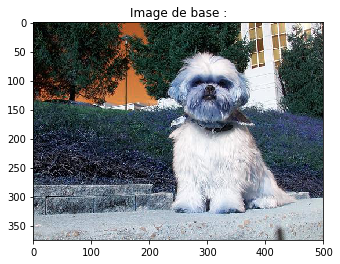

In [0]:
plt.imshow(cv_img[0])
plt.title("Image de base :")
plt.savefig('imageBase.png', bbox_inches='tight')
plt.show()

## Preprocessing :

#### On applique un filtre gaussien :

In [0]:
# Ajout gaussian filter :
cv_img_GF = []
for img in cv_img: 
    img_gf = cv2.GaussianBlur(img,(7,7),0)
    cv_img_GF.append(img_gf)
# images test:     
cv_img_GF_test = []
for img in cv_img_test: 
    img_gf = cv2.GaussianBlur(img,(7,7),0)
    cv_img_GF_test.append(img_gf)    

#### On convertit les images en noir et blanc (+ apperçu) :

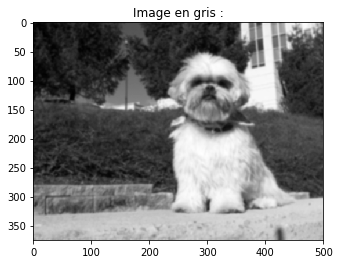

In [0]:
#Convert original to gray:
cv_img_gray= vect_to_gray(cv_img_GF)
plt.imshow(cv_img_gray[0],cmap='gray')
plt.title("Image en gris :")
plt.savefig('imageGris.png', bbox_inches='tight')
# images test: 
cv_img_gray_test= vect_to_gray(cv_img_test)

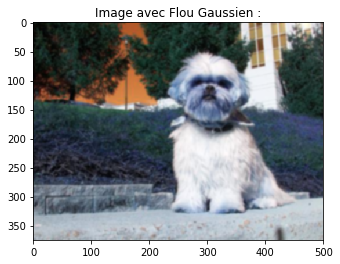

In [0]:
plt.imshow(cv_img_GF[0],cmap='gray')
plt.title("Image avec Flou Gaussien :")
plt.savefig('imageFlou.png', bbox_inches='tight')

#### On applique un equalizer d'histogramme pour régler un meilleur contrast sur nos photos : 

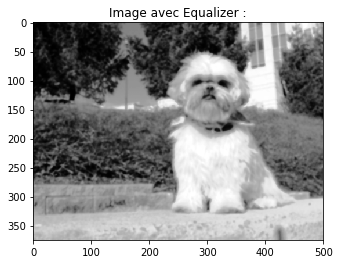

In [0]:
cv_img_eq=equalizer(cv_img_gray)
plt.imshow(cv_img_eq[0],cmap='gray')
plt.title("Image avec Equalizer :")
plt.savefig('imageEqualizer.png', bbox_inches='tight')
# images test: 
cv_img_eq_test=equalizer(cv_img_gray_test)

#### Apperçu d'un histogramme equalizé : 

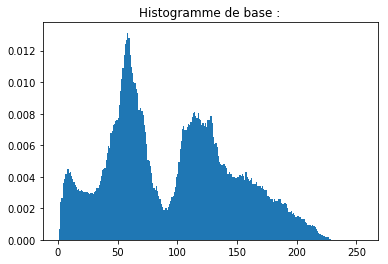

In [0]:
n, bins, patches = plt.hist(cv_img_GF[540].flatten(), bins=range(256),density=True)
plt.title("Histogramme de base :")
plt.savefig('HistoBase.png', bbox_inches='tight')
plt.show()

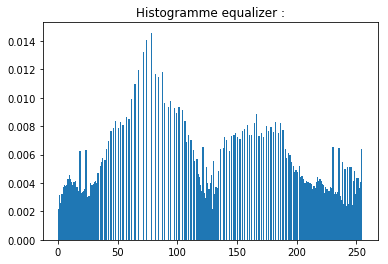

In [0]:
n, bins, patches = plt.hist(cv_img_eq[540].flatten(), bins=range(256),density=True)
plt.title("Histogramme equalizer :")
plt.savefig('HistoEqualizer.png', bbox_inches='tight')
plt.show()

#### On retire l'arrière plan de l'image focus sur le chien : 

In [0]:
#Remove Background
mask_img = vect_no_background_mask(cv_img,cv_rectangle)

100%|████████████████████████████████████████████████████████████████████████████████| 679/679 [16:46<00:00,  1.48s/it]


In [0]:
#Remove Background test images :
mask_img_test = vect_no_background_mask(cv_img_test,cv_rectangle_test)

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [06:33<00:00,  2.38s/it]


#### Création de notre collection d'image après preprocessing :

In [0]:
# CV image final : 
cv_final = []
for i in range(0,len(cv_img_eq)):
    cv_final.append(apply_mask(cv_img_eq[i],mask_img[i]))

In [0]:
# CV image final TEST : 
cv_final_test = []
for i in range(0,len(cv_img_eq_test)):
    cv_final_test.append(apply_mask(cv_img_eq_test[i],mask_img_test[i]))

#### Apperçu Avant/ Après : 

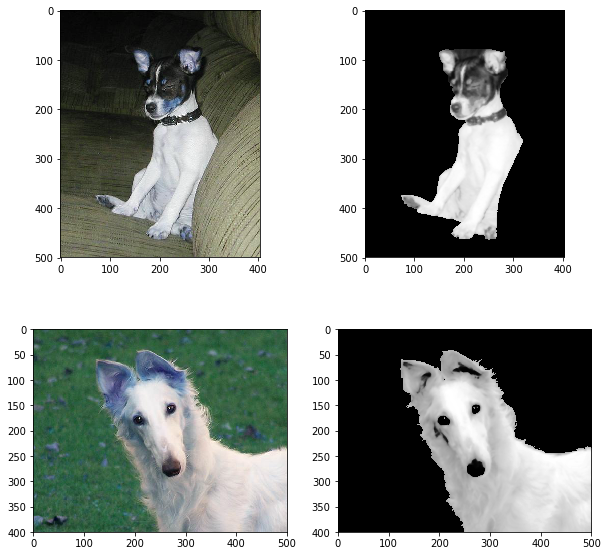

In [0]:
f, fig = plt.subplots(2,2,figsize=(10,10))
fig[0,0].imshow(cv_img[259])
fig[0,1].imshow(cv_final[259],cmap='gray')
fig[1,0].imshow(cv_img[501])
fig[1,1].imshow(cv_final[501],cmap='gray')
plt.savefig('imagePreprocess.png', bbox_inches='tight')

### SIFT KEY POINT DETECTEUR : 
#### Visualisation détection avant / aprés preprocessing : 

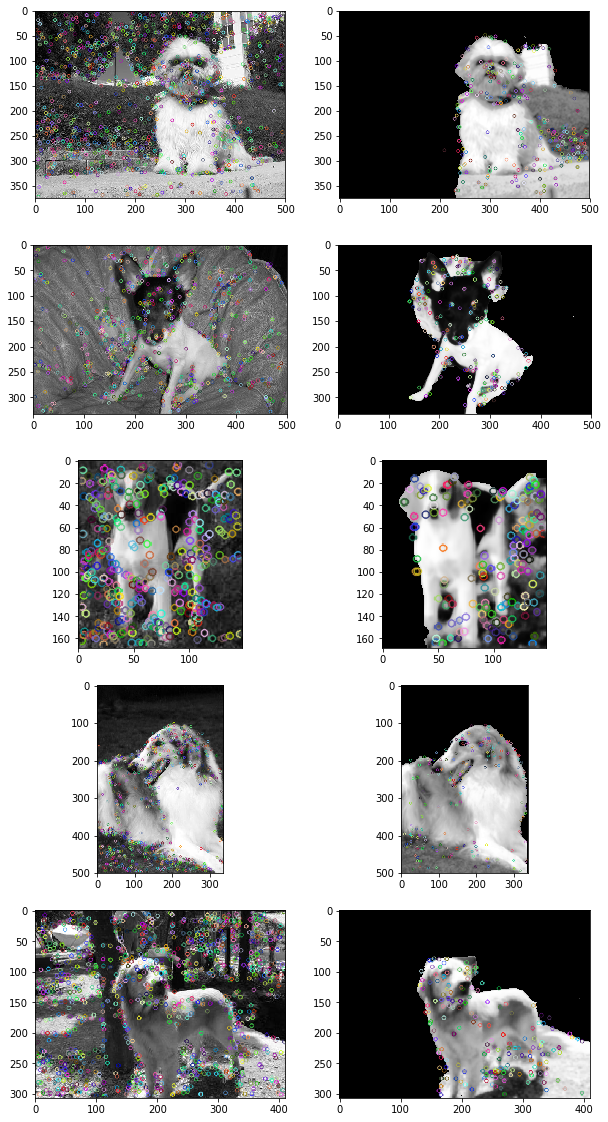

In [0]:
import copy
index_test = [0,191,332,464,593]
f, axarr = plt.subplots(5,2,figsize=(10,20))

for i,j in zip(index_test,range(0,5)):     
    img_init = copy.copy(cv_img[i])
    img_final = copy.copy(cv_final[i])
    gray_init = cv2.cvtColor(img_init,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp_init = sift.detect(gray_init,None)
    kp_final = sift.detect(img_final,None)
    img_init1 =cv2.drawKeypoints(gray_init,kp_init,img_init)
    img_final = cv2.drawKeypoints(img_final,kp_final,img_final)
    axarr[j,0].imshow(img_init1)
    axarr[j,1].imshow(img_final)
plt.savefig('SiftAVantApres.png', bbox_inches='tight')

### Extraction des keypoint avec SIFT : 
#### Supression de certaine images en erreur (pas de détection, concerne - de 2% des images)

In [0]:
cv_kp,cv_desc,cv_kp_file = extract_desc_sift(cv_final,cv_filename)

erreur image :n02086240_3814
erreur image :n02086240_789
erreur image :n02087046_5347
erreur image :n02089973_1000
erreur image :n02089973_1132
erreur image :n02089973_1490
erreur image :n02089973_1877
erreur image :n02089973_1888
erreur image :n02089973_3433
erreur image :n02089973_437
erreur image :n02090622_6771
erreur image :n02099601_5051


In [0]:
# images test :
cv_kp_test,cv_desc_test,cv_kp_file_test = extract_desc_sift(cv_final_test,cv_filename_test)

erreur image :n02089973_2415
erreur image :n02089973_3113
erreur image :n02090622_7351


In [0]:
#Création dataframe de descripteur :
df_kp = pd.DataFrame(data = cv_desc, index = cv_kp)

In [0]:
print(df_kp.shape)
df_kp.head(5)

(220718, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
<KeyPoint 00000195A03819C0>,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0,...,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
<KeyPoint 00000195A0381EA0>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,2.0,...,0.0,4.0,45.0,11.0,4.0,4.0,2.0,0.0,0.0,1.0
<KeyPoint 00000195A03810C0>,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,0.0,...,0.0,8.0,2.0,2.0,2.0,1.0,0.0,0.0,3.0,2.0
<KeyPoint 00000195A0381A20>,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,115.0,0.0,...,0.0,0.0,3.0,16.0,17.0,5.0,0.0,0.0,0.0,0.0
<KeyPoint 00000195A03812D0>,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,150.0,11.0,...,0.0,7.0,12.0,74.0,34.0,1.0,0.0,0.0,0.0,0.0


### Clustering des key point avec l'algo Kmeans : 

In [0]:
X = np.array(df_kp)
#Kmeans : 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
C = kmeans.cluster_centers_

#### Dataframe des KP :

In [0]:
df_kp["image_name"]= cv_kp_file
df_kp["cluster"] = labels
df_kp.head(10)

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,image_name,cluster
<KeyPoint 00000195A03819C0>,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,n02086240_1011,30
<KeyPoint 00000195A0381EA0>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,2.0,...,45.0,11.0,4.0,4.0,2.0,0.0,0.0,1.0,n02086240_1011,30
<KeyPoint 00000195A03810C0>,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,3.0,2.0,n02086240_1011,55
<KeyPoint 00000195A0381A20>,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,115.0,0.0,...,3.0,16.0,17.0,5.0,0.0,0.0,0.0,0.0,n02086240_1011,70
<KeyPoint 00000195A03812D0>,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,150.0,11.0,...,12.0,74.0,34.0,1.0,0.0,0.0,0.0,0.0,n02086240_1011,10
<KeyPoint 00000195A0381270>,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,1.0,...,24.0,8.0,3.0,1.0,0.0,0.0,0.0,1.0,n02086240_1011,30
<KeyPoint 00000195A0381F90>,16.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,140.0,81.0,...,67.0,108.0,24.0,0.0,0.0,0.0,0.0,0.0,n02086240_1011,21
<KeyPoint 00000195CF9B4BA0>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,0.0,0.0,4.0,63.0,16.0,2.0,n02086240_1011,6
<KeyPoint 00000195CF9B4BD0>,44.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,144.0,...,44.0,144.0,97.0,14.0,0.0,0.0,0.0,0.0,n02086240_1011,80
<KeyPoint 00000195CF9B4C00>,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,13.0,...,53.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,n02086240_1011,63


In [0]:
dict_label = {"n02086240":"shih-tzu","n02087046":"toy-terrier","n02089973":"english-foxhound","n02090622":"borzoi","n02099601":"golden-retriever"}

In [0]:
# Ajout de la colonne label :
df_kp['label_code'] = df_kp['image_name'].astype(str).str[:9]
df_kp['label'] = df_kp['label_code'].map(dict_label)

In [0]:
df_kp.head(5)

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,image_name,cluster,label_code,label
<KeyPoint 00000195A03819C0>,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,n02086240_1011,30,n02086240,shih-tzu
<KeyPoint 00000195A0381EA0>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,2.0,...,4.0,4.0,2.0,0.0,0.0,1.0,n02086240_1011,30,n02086240,shih-tzu
<KeyPoint 00000195A03810C0>,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,0.0,...,2.0,1.0,0.0,0.0,3.0,2.0,n02086240_1011,55,n02086240,shih-tzu
<KeyPoint 00000195A0381A20>,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,115.0,0.0,...,17.0,5.0,0.0,0.0,0.0,0.0,n02086240_1011,70,n02086240,shih-tzu
<KeyPoint 00000195A03812D0>,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,150.0,11.0,...,34.0,1.0,0.0,0.0,0.0,0.0,n02086240_1011,10,n02086240,shih-tzu


In [0]:
histogramme_cluster = df_kp.groupby(['label_code','cluster']).count()['label']

### Création des histogrammes :
##### VIsualisation des histogrammes moyen pour chaque race :

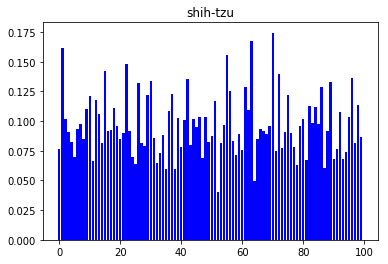

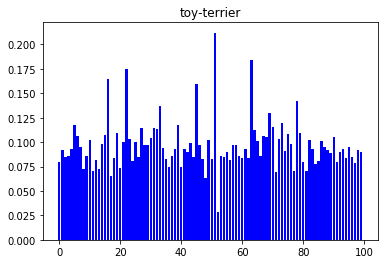

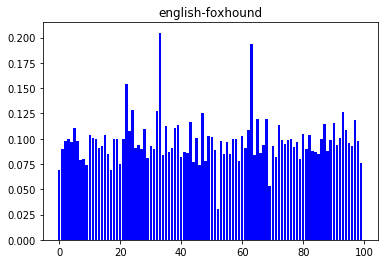

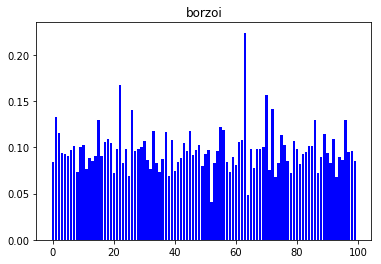

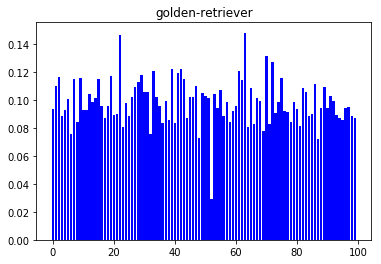

In [0]:
#Histogramme moyen pour chaque race : 
from sklearn.preprocessing import normalize
abscisse = np.array(range(0,100))
for k,i in zip(dict_label,range(0,len(dict_label))):
    data = np.array(histogramme_cluster[k])
    data = normalize(data[:,np.newaxis], axis=0).ravel()
    plt.bar(abscisse, data, color="blue")
    plt.title(dict_label[k])
    plt.savefig(dict_label[k])
    plt.show()

In [0]:
#Création du dataframe des histogrammes de chaque images d'entrainement :
df_hist = pd.DataFrame(columns=range(0,100))
histo_image = df_kp.groupby(['image_name','cluster']).count()

for file in cv_kp_file:
    temp_col = histo_image.loc[file].label.index
    temp_val = np.array(histo_image.loc[file].label)
    temp_val = normalize(temp_val[:,np.newaxis], axis=0).ravel()
    df_hist.loc[file,temp_col] = temp_val

In [0]:
dict_file_label = dict(zip(df_kp["image_name"],df_kp["label"]))
df_hist["label"] =  df_hist.index.to_series().map(dict_file_label)  

In [0]:
df_hist.fillna(0,inplace=True)
df_hist.head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
n02086240_1011,0.024056,0.096225,0.048113,0.048113,0.120281,0.048113,0.096225,0.048113,0.024056,0.048113,...,0.048113,0.072169,0.024056,0.072169,0.048113,0.096225,0.216506,0.144338,0.120281,shih-tzu
n02086240_1016,0.102003,0.170005,0.034001,0.068002,0.068002,0.000000,0.068002,0.102003,0.034001,0.000000,...,0.034001,0.102003,0.000000,0.034001,0.068002,0.034001,0.034001,0.204006,0.000000,shih-tzu
n02086240_1059,0.095211,0.309436,0.261831,0.047606,0.047606,0.047606,0.071408,0.095211,0.047606,0.095211,...,0.095211,0.119014,0.000000,0.047606,0.023803,0.119014,0.142817,0.071408,0.071408,shih-tzu
n02086240_1078,0.000000,0.192673,0.000000,0.096337,0.048168,0.000000,0.096337,0.048168,0.192673,0.048168,...,0.144505,0.192673,0.048168,0.000000,0.289010,0.144505,0.096337,0.144505,0.048168,shih-tzu
n02086240_10785,0.000000,0.226134,0.188445,0.075378,0.037689,0.000000,0.188445,0.075378,0.000000,0.037689,...,0.037689,0.075378,0.000000,0.075378,0.037689,0.263822,0.037689,0.113067,0.037689,shih-tzu
n02086240_1082,0.028217,0.056433,0.197516,0.056433,0.000000,0.000000,0.141083,0.028217,0.028217,0.000000,...,0.000000,0.056433,0.028217,0.000000,0.000000,0.225733,0.056433,0.084650,0.000000,shih-tzu
n02086240_110,0.098853,0.131804,0.082378,0.115329,0.049427,0.082378,0.065902,0.049427,0.065902,0.148280,...,0.082378,0.131804,0.065902,0.049427,0.082378,0.049427,0.115329,0.098853,0.098853,shih-tzu
n02086240_1142,0.000000,0.000000,0.143963,0.000000,0.000000,0.000000,0.000000,0.071982,0.071982,0.071982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.215945,0.143963,0.071982,0.071982,shih-tzu
n02086240_11622,0.052235,0.026118,0.104470,0.182823,0.078353,0.104470,0.156706,0.052235,0.078353,0.026118,...,0.000000,0.026118,0.000000,0.078353,0.078353,0.078353,0.156706,0.208941,0.026118,shih-tzu
n02086240_11692,0.070535,0.070535,0.180255,0.125395,0.109720,0.141069,0.047023,0.101883,0.031349,0.062697,...,0.094046,0.000000,0.039186,0.094046,0.023512,0.062697,0.047023,0.023512,0.117558,shih-tzu


In [0]:
# dataframe de test : 
#Création dataframe de descripteur :
df_kp_test = pd.DataFrame(data = cv_desc_test, index = cv_kp_test)
arr_kp_test = np.array(df_kp_test)
label_test = kmeans.predict(arr_kp_test)
df_kp_test["image_name"]= cv_kp_file_test
df_kp_test["cluster"] = label_test
df_kp_test.head(8)

df_kp_test['label_code'] = df_kp_test['image_name'].astype(str).str[:9]
df_kp_test['label'] = df_kp_test['label_code'].map(dict_label)

In [0]:
#Création des histogrammes test :
df_hist_test = pd.DataFrame(columns=range(0,100))
histo_image_test = df_kp_test.groupby(['image_name','cluster']).count()

for file in cv_kp_file_test:
    temp_col = histo_image_test.loc[file].label.index
    temp_val = np.array(histo_image_test.loc[file].label)
    temp_val = normalize(temp_val[:,np.newaxis], axis=0).ravel()
    df_hist_test.loc[file,temp_col] = temp_val

In [0]:
df_kp_test['label_code'] = df_kp_test['image_name'].astype(str).str[:9]
df_kp_test['label'] = df_kp_test['label_code'].map(dict_label)

dict_file_label_test = dict(zip(df_kp_test["image_name"],df_kp_test["label"]))
df_hist_test["label"] =  df_hist_test.index.to_series().map(dict_file_label_test)

df_hist_test.fillna(0,inplace=True)
df_hist_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
n02086240_11085,0.029488,0.176930,0.147442,0.058977,0.029488,0.058977,0.088465,0.058977,0.147442,0.176930,...,0.000000,0.058977,0.147442,0.029488,0.147442,0.117954,0.088465,0.058977,0.029488,shih-tzu
n02086240_11139,0.040792,0.067986,0.115577,0.067986,0.095181,0.033993,0.033993,0.244751,0.088382,0.244751,...,0.074785,0.122375,0.176764,0.040792,0.074785,0.101979,0.040792,0.067986,0.054389,shih-tzu
n02086240_11420,0.049207,0.172224,0.098414,0.000000,0.049207,0.049207,0.073810,0.147620,0.024603,0.049207,...,0.098414,0.098414,0.123017,0.049207,0.098414,0.221431,0.024603,0.098414,0.024603,shih-tzu
n02086240_11539,0.000000,0.035680,0.053520,0.017840,0.000000,0.160561,0.053520,0.214081,0.017840,0.107041,...,0.053520,0.089200,0.124881,0.017840,0.000000,0.035680,0.017840,0.000000,0.071360,shih-tzu
n02086240_11551,0.035806,0.107417,0.035806,0.179029,0.035806,0.000000,0.071611,0.035806,0.000000,0.071611,...,0.035806,0.035806,0.143223,0.143223,0.214834,0.179029,0.071611,0.179029,0.035806,shih-tzu


### Implémentation du modèle prédictif à partir des histogrammes :

In [0]:
# Jeu d'entrainement : 
X_train = df_hist.iloc[:,:100]
y = df_hist.iloc[:,100]

In [0]:
# Entrainement modèle prédictif:
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class='crammer_singer')
clf.fit(X_train,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [0]:
# jeu de test :
X_test = np.array(df_hist_test.iloc[:,:-1])

In [0]:
#Prédiction :
prediction = clf.predict(X_test)

In [0]:
from sklearn.metrics import precision_score
precision_score(df_hist_test['label'],prediction,average="micro")

0.41975308641975306

### Comparaison du clustering avec / sans preprocessing : 

In [0]:
#On récupère les KP sur les images initiales ( limités à 100 par image):
cv_kp_init,cv_desc_init,cv_kp_file_init = extract_desc_sift_limit(cv_img,cv_filename,100)

In [0]:
#Création du df des KP des images initiales :
df_kp_init = pd.DataFrame(data = cv_desc_init, index = cv_kp_init)
arr_kp_init = np.array(df_kp_init)
label_init = kmeans.predict(arr_kp_init)
df_kp_init["image_name"]= cv_kp_file_init
df_kp_init["cluster"] = label_init
df_kp_init.head(8)

df_kp_init['label_code'] = df_kp_init['image_name'].astype(str).str[:9]
df_kp_init['label'] = df_kp_init['label_code'].map(dict_label)

In [0]:
#Création des histogrammes test :
df_hist_init = pd.DataFrame(columns=range(0,100))
histo_image_init = df_kp_init.groupby(['image_name','cluster']).count()

for file in cv_kp_file_init:
    temp_col = histo_image_init.loc[file].label.index
    temp_val = np.array(histo_image_init.loc[file].label)
    temp_val = normalize(temp_val[:,np.newaxis], axis=0).ravel()
    df_hist_init.loc[file,temp_col] = temp_val

In [0]:
df_kp_init['label_code'] = df_kp_init['image_name'].astype(str).str[:9]
df_kp_init['label'] = df_kp_init['label_code'].map(dict_label)

dict_file_label_init = dict(zip(df_kp_init["image_name"],df_kp_init["label"]))
df_hist_init["label"] =  df_hist_init.index.to_series().map(dict_file_label_init)

df_hist_init.fillna(0,inplace=True)
df_hist_init.head(5)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
n02086240_1011,0.000000,0.000000,0.000000,0.051164,0.153493,0.153493,0.051164,0.255822,0.000000,0.051164,...,0.051164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,shih-tzu
n02086240_1016,0.108465,0.108465,0.000000,0.000000,0.054233,0.000000,0.000000,0.108465,0.000000,0.000000,...,0.000000,0.000000,0.108465,0.108465,0.054233,0.054233,0.000000,0.216930,0.054233,shih-tzu
n02086240_1059,0.000000,0.107211,0.107211,0.000000,0.000000,0.053606,0.053606,0.000000,0.053606,0.107211,...,0.000000,0.107211,0.160817,0.000000,0.000000,0.107211,0.053606,0.160817,0.053606,shih-tzu
n02086240_1078,0.067729,0.000000,0.067729,0.000000,0.270914,0.000000,0.067729,0.067729,0.000000,0.000000,...,0.000000,0.067729,0.135457,0.067729,0.000000,0.067729,0.000000,0.000000,0.000000,shih-tzu
n02086240_10785,0.000000,0.123560,0.061780,0.000000,0.061780,0.000000,0.000000,0.123560,0.000000,0.123560,...,0.000000,0.000000,0.000000,0.185341,0.000000,0.123560,0.061780,0.061780,0.061780,shih-tzu


In [0]:
from sklearn.manifold import TSNE
tsne_init = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_init = tsne_init.fit_transform(df_hist_init.iloc[:,0:100].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 679 samples in 0.005s...
[t-SNE] Computed neighbors for 679 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 679 / 679
[t-SNE] Mean sigma: 0.271539
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.115906
[t-SNE] Error after 300 iterations: 1.408578


In [0]:
df_tsne_init = df_hist_init.copy()
df_tsne_init['x-tsne'] = tsne_results_init[:,0]
df_tsne_init['y-tsne'] = tsne_results_init[:,1]

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_hist.iloc[:,0:100].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 667 samples in 0.006s...
[t-SNE] Computed neighbors for 667 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 667 / 667
[t-SNE] Mean sigma: 0.216944
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.689285
[t-SNE] Error after 300 iterations: 1.560633


In [0]:
df_tsne = df_hist.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

In [0]:
df_tsne[df_tsne['y-tsne']<-30].index

Index(['n02099601_342'], dtype='object')

In [0]:
df_tsne.drop(['n02099601_342'],inplace=True)

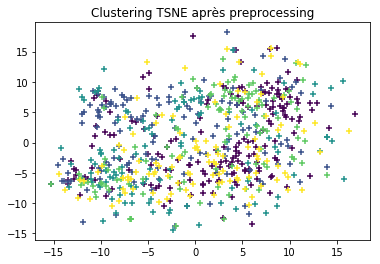

In [0]:
import matplotlib
dict_color = {"shih-tzu":0,"toy-terrier":1,"english-foxhound":2,"borzoi":3,"golden-retriever":4}
df_tsne['color'] = df_tsne['label'].astype(str).map(dict_color)
plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'],marker='+',c=df_tsne['color'])
plt.title("Clustering TSNE après preprocessing")
plt.savefig("clusterApres.png")
plt.show()

In [0]:
#df_tsne_init.drop(df_tsne_init.index[13],inplace=True)

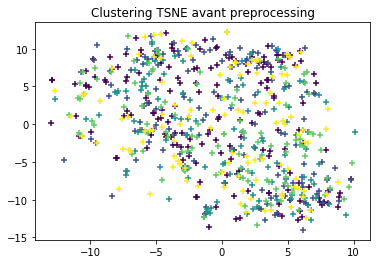

In [0]:
import matplotlib
dict_color = {"shih-tzu":0,"toy-terrier":1,"english-foxhound":2,"borzoi":3,"golden-retriever":4}
df_tsne_init['color'] = df_tsne_init['label'].astype(str).map(dict_color)
plt.scatter(df_tsne_init['x-tsne'], df_tsne_init['y-tsne'],marker='+',c=df_tsne['color'])
plt.title("Clustering TSNE avant preprocessing")
plt.savefig("clusterAvant.png")
plt.show()